# Data Downtime Challenge | Exercise 1

## 0. Setup

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
from datetime import datetime, timedelta
from matplotlib import pyplot as plt

In [3]:
import sys
sys.path.append("..")

In [4]:
from data.utils.exercise_1 import all_days, show_reports

In [5]:
import sqlite3

conn = sqlite3.connect("../data/dbs/Ex1.db")
c = conn.cursor()

## 1. Introduction

Welcome to the Data Downtime Challenge! In this exercise, we'll learn Data Observability through practice on some sample datasets. Each subproblem will ask you to craft some `SQL` queries that help us learn about the state of our tables and identify Data Downtime issues.

For these exercises, we'll be using mock astronomical data to identify habitable planets.

![SegmentLocal](/tree/data/assets/planets.gif "segment")

The `Ex1.db` database contains a single table, `EXOPLANETS`, which has information on nearly 2000 exoplanets across the Milky Way Galaxy.

In [6]:
c.execute("PRAGMA table_info(EXOPLANETS);")
c.fetchall()

[(0, '_id', 'TEXT', 0, None, 0),
 (1, 'distance', 'REAL', 0, None, 0),
 (2, 'g', 'REAL', 0, None, 0),
 (3, 'orbital_period', 'REAL', 0, None, 0),
 (4, 'avg_temp', 'REAL', 0, None, 0),
 (5, 'date_added', 'TEXT', 0, None, 0)]

A database entry in `EXOPLANETS` contains the following info:

0. `_id`: A UUID corresponding to the planet.
1. `distance`: Distance from Earth, in lightyears.
2. `g`: Surface gravity as a multiple of $g$, the gravitational force constant.
3. `orbital_period`: Length of a single orbital cycle in days.
4. `avg_temp`: Average surface temperature in degrees Kelvin.
5. `date_added`: The date our system discovered the planet and added it automatically to our databases.

Note that one or more of `distance`, `g`, `orbital_period`, and `avg_temp` may be `NULL` for a given planet as a result of missing or erroneous data.

In [7]:
pd.read_sql_query("SELECT * FROM EXOPLANETS LIMIT 10", conn)

,_id,distance,g,orbital_period,avg_temp,date_added
0,c168b188-ef0c-4d6a-8cb2-f473d4154bdb,34.627304,NaN,476.480044,NaN,2020-01-01
1,e7b56e84-41f4-4e62-b078-01b076cea369,110.196920,2.525074,839.837817,NaN,2020-01-01
2,a27030a0-e4b4-4bd7-8d24-5435ed86b395,26.695795,10.276497,301.018816,NaN,2020-01-01
3,54f9cf85-eae9-4f29-b665-855357a14375,54.888352,NaN,173.788968,328.644125,2020-01-01
4,4d06ec88-f5c8-4d03-91ef-7493a12cd89e,153.264217,0.922875,200.712662,NaN,2020-01-01
5,e16250b8-2d9d-49f3-aaef-58eed9a8864c,7.454811,5.503701,763.561710,245.129285,2020-01-01
6,a0a6bf97-90d5-4686-8ccb-10753f8d335e,4.925946,0.953473,486.053323,267.786557,2020-01-01
7,b28b4e19-8517-4ab5-97f0-c445f1aae6c4,94.540173,7.118254,629.287426,368.859206,2020-01-01
8,7e34e44e-663f-491c-96c5-bb5acb8d5f1e,19.786255,3.999081,744.106326,180.445029,2020-01-01
9,305e8ea0-663b-4311-b6b3-4198c051c335,95.654030,0.677212,472.344447,NaN,2020-01-01


## 2. Exercise: Visualizing Freshness

Grouping by the `DATE_ADDED` column can give us insight into how `EXOPLANETS` updates daily. For example, we can query for the number of new IDs added per day:

In [8]:
SQL = """
SELECT
    DATE_ADDED,
    COUNT(*) AS ROWS_ADDED
FROM
    EXOPLANETS
GROUP BY
    DATE_ADDED
"""

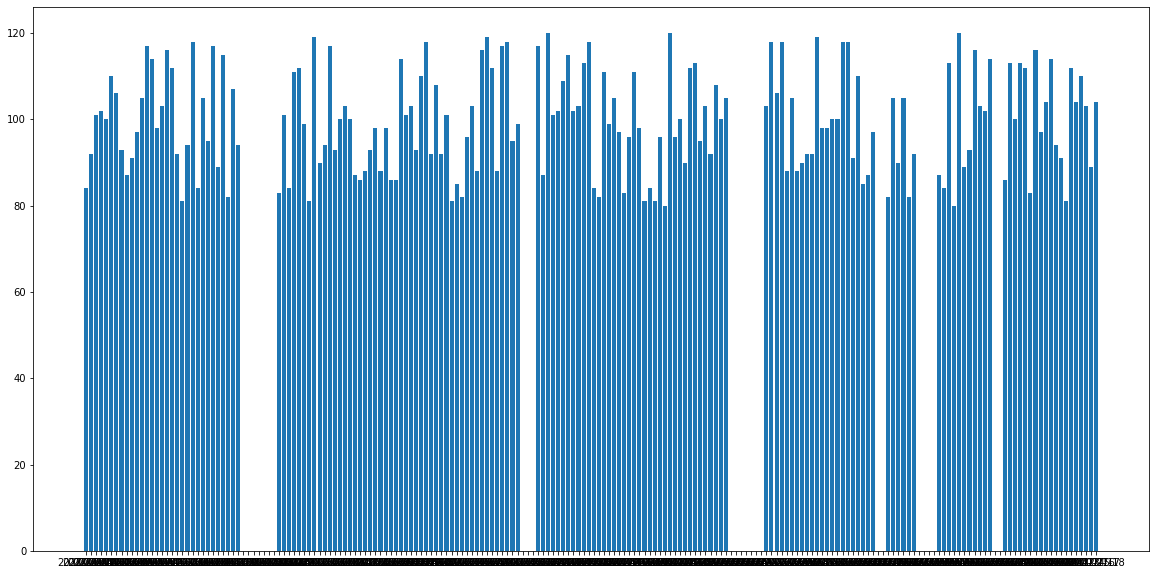

In [9]:
rows_added = pd.read_sql_query(SQL, conn)
rows_added = rows_added \
    .rename(columns={clmn: clmn.lower() for clmn in rows_added.columns})
rows_added = rows_added.set_index("date_added")
rows_added = rows_added.reindex(all_days)
plt.figure(figsize=(20, 10))
plt.bar(all_days, height=rows_added["rows_added"])
plt.show()

It looks like `EXOPLANETS` typically updates with around 100 new entries each day. Something looks off in a few places, though. We have what we'd call a **freshness** incident -- on a couple of occasions, the table doesn't update at all for a 3 or more days. It has "stale" (3+ day old) data.

Try writing some `SQL` code that returns timestamps for when freshness incidents occur. Feel free to use the query above as a starting point.

- *Hint 1*: The `LAG` window function should help in comparing two subsequent rows in a query.
- *Hint 2*: `SQLite` uses `JULIANDAY()` to cast an object to a date.
- *Hint 3*: An example solution is given in `solutions/exercise_1.ipynb`, if needed for comparison.

In [10]:
# YOUR CODE HERE
SQL = """
WITH RC_UPDATES AS(
    SELECT
        DATE_ADDED,
        COUNT(*) AS ROWS_ADDED
    FROM
        EXOPLANETS
    GROUP BY
        DATE_ADDED
),
NUM_DAYS_UPDATES AS(
    SELECT
        DATE_ADDED,
        JULIANDAY(DATE_ADDED) - JULIANDAY(LAG(DATE_ADDED) OVER(ORDER BY DATE_ADDED)) AS DAYS_SINCE_UPDATE
    FROM
        RC_UPDATES
)
SELECT
    *
FROM
    NUM_DAYS_UPDATES
WHERE
    DAYS_SINCE_UPDATE > 1
"""
# END YOUR CODE

In [11]:
freshness_anoms = pd.read_sql_query(SQL, conn)
freshness_anoms = freshness_anoms \
    .rename(columns={clmn: clmn.lower() for clmn in freshness_anoms.columns})
freshness_anoms

,date_added,days_since_update
0,2020-02-08,8.0
1,2020-03-30,4.0
2,2020-05-14,8.0
3,2020-06-07,3.0
4,2020-06-17,5.0
5,2020-06-30,3.0


The `show_reports` function from `utils` will help us visualize our results.

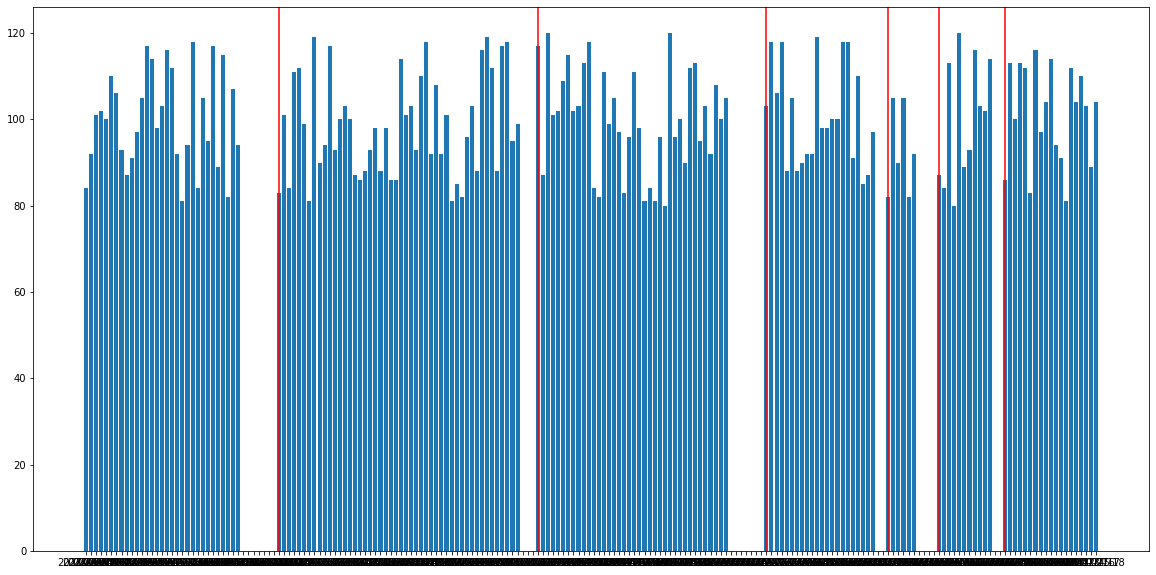

In [12]:
show_reports(rows_added, freshness_anoms["date_added"], "rows_added")

## 3. Exercise: Null Rates

We can also look at the rate of new `NULL` entries for different columns on a daily basis:

In [13]:
SQL = """
SELECT
    DATE_ADDED,
    CAST(SUM(CASE WHEN DISTANCE IS NULL THEN 1 ELSE 0 END) AS FLOAT) / COUNT(*) AS DISTANCE_NULL_RATE,
    CAST(SUM(CASE WHEN G IS NULL THEN 1 ELSE 0 END) AS FLOAT) / COUNT(*) AS G_NULL_RATE,
    CAST(SUM(CASE WHEN ORBITAL_PERIOD IS NULL THEN 1 ELSE 0 END) AS FLOAT) / COUNT(*) AS ORBITAL_PERIOD_NULL_RATE,
    CAST(SUM(CASE WHEN AVG_TEMP IS NULL THEN 1 ELSE 0 END) AS FLOAT) / COUNT(*) AS AVG_TEMP_NULL_RATE    
FROM
    EXOPLANETS
GROUP BY
    DATE_ADDED
"""

In [14]:
null_rates = pd.read_sql_query(SQL, conn)
null_rates = null_rates \
    .rename(columns={clmn: clmn.lower() for clmn in null_rates.columns})
null_rates = null_rates.set_index("date_added")
null_rates = null_rates.reindex(all_days)

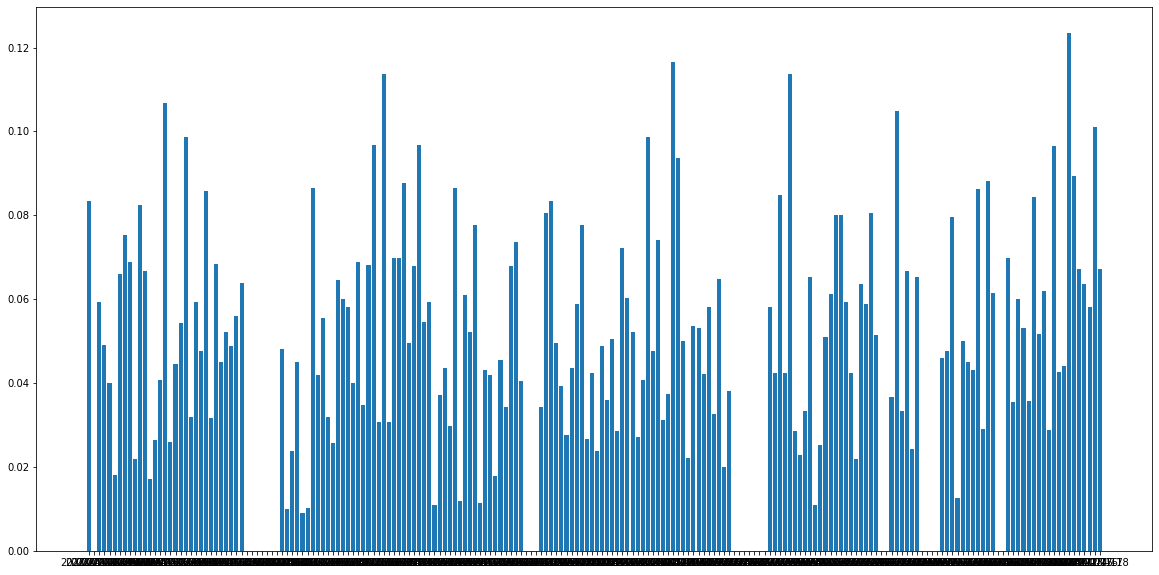

In [15]:
plt.figure(figsize=(20, 10))
plt.bar(all_days, height=null_rates["distance_null_rate"])
plt.show()

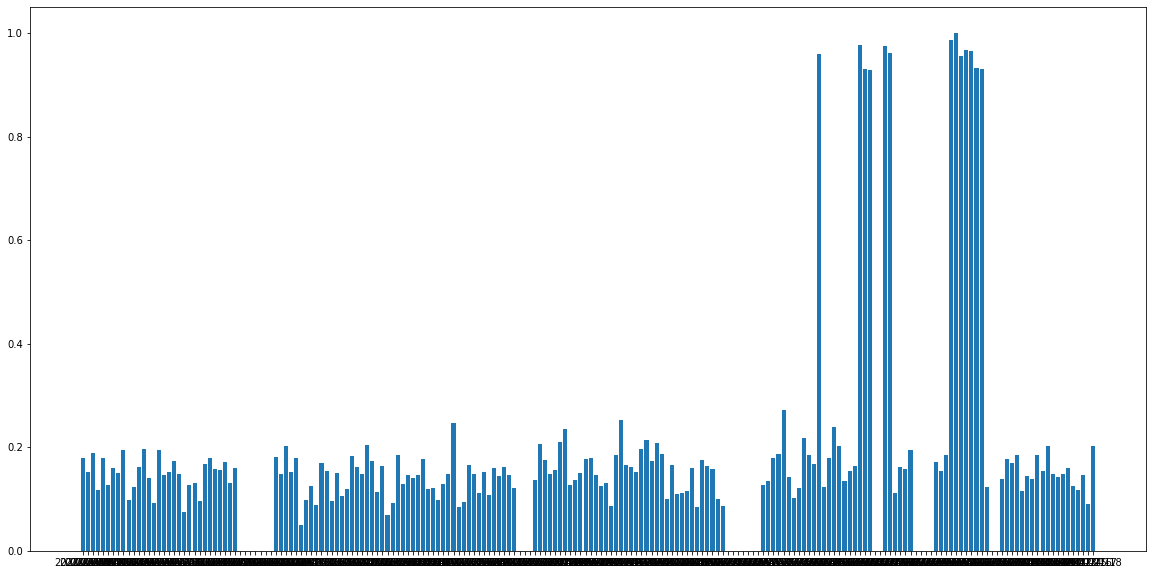

In [16]:
plt.figure(figsize=(20, 10))
plt.bar(all_days, height=null_rates["g_null_rate"])
plt.show()

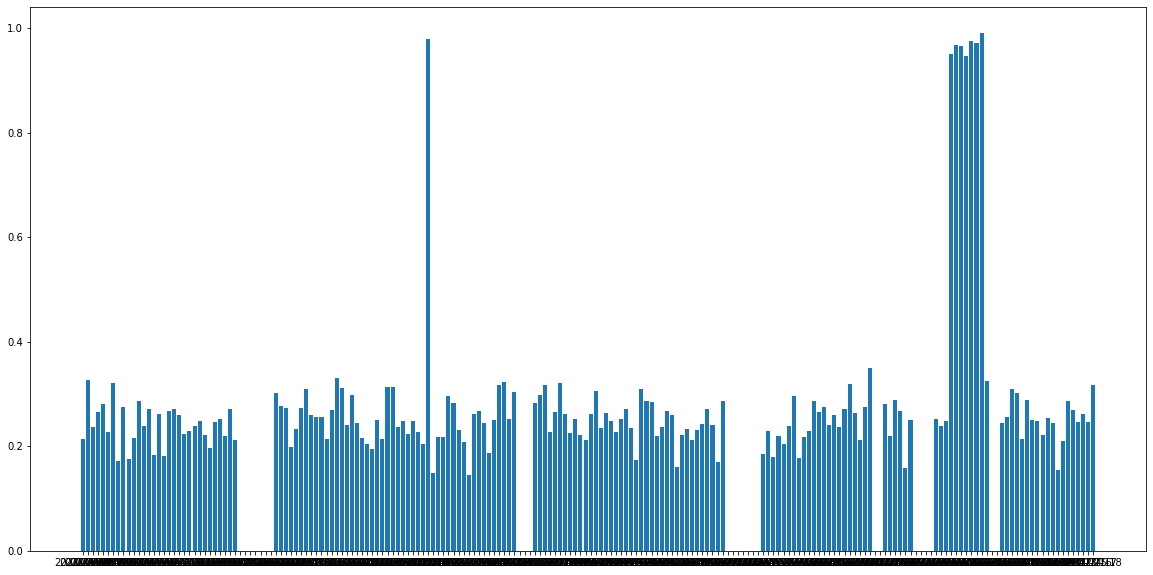

In [17]:
plt.figure(figsize=(20, 10))
plt.bar(all_days, height=null_rates["orbital_period_null_rate"])
plt.show()

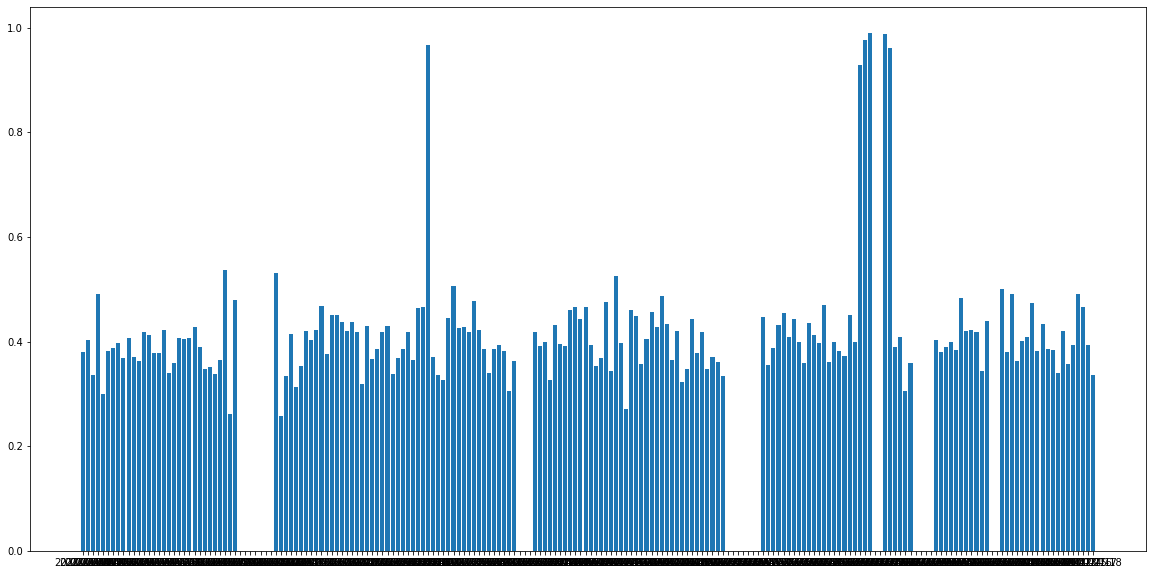

In [18]:
plt.figure(figsize=(20, 10))
plt.bar(all_days, height=null_rates["avg_temp_null_rate"])
plt.show()

Some of the fields in the table show "spikes" in the rate of null values at certain times. Try to write a simple `SQL` query to identify timestamps with unusually high null rates. Again, feel free to use the query above as a starting point.

- *Hint 1*: It may help to introduce a column that identifies which field (or fields) have the anomalous null rate for a given timestamp.
- *Hint 2*: Once again, a sample solution is available in `solutions/exercise_1.ipynb`, if needed.

In [19]:
# YOUR CODE HERE
SQL = """
WITH NULL_RATES AS(
    SELECT
        DATE_ADDED,
        CAST(SUM(CASE WHEN DISTANCE IS NULL THEN 1 ELSE 0 END) AS FLOAT) / COUNT(*) AS DISTANCE_NULL_RATE,
        CAST(SUM(CASE WHEN G IS NULL THEN 1 ELSE 0 END) AS FLOAT) / COUNT(*) AS G_NULL_RATE,
        CAST(SUM(CASE WHEN ORBITAL_PERIOD IS NULL THEN 1 ELSE 0 END) AS FLOAT) / COUNT(*) AS ORBITAL_PERIOD_NULL_RATE,
        CAST(SUM(CASE WHEN AVG_TEMP IS NULL THEN 1 ELSE 0 END) AS FLOAT) / COUNT(*) AS AVG_TEMP_NULL_RATE    
    FROM
        EXOPLANETS
    GROUP BY
        DATE_ADDED
)
SELECT
    *
FROM
    NULL_RATES
WHERE
    AVG_TEMP_NULL_RATE > 0.9
"""
# END YOUR CODE

In [20]:
null_rate_anoms = pd.read_sql_query(SQL, conn)
null_rate_anoms = null_rate_anoms \
    .rename(columns={clmn: clmn.lower() for clmn in null_rate_anoms.columns})
null_rate_anoms

,date_added,distance_null_rate,g_null_rate,orbital_period_null_rate,avg_temp_null_rate
0,2020-03-09,0.010870,0.119565,0.978261,0.967391
1,2020-06-02,0.058824,0.976471,0.211765,0.929412
2,2020-06-03,0.080460,0.931034,0.275862,0.977011
3,2020-06-04,0.051546,0.927835,0.350515,0.989691
4,2020-06-07,0.036585,0.975610,0.280488,0.987805
5,2020-06-08,0.104762,0.961905,0.219048,0.961905


Once again, we'll use the `show_reports` function to visualize the results of our query. Feel free to continue running the above and below cells until you're happy with the reports!

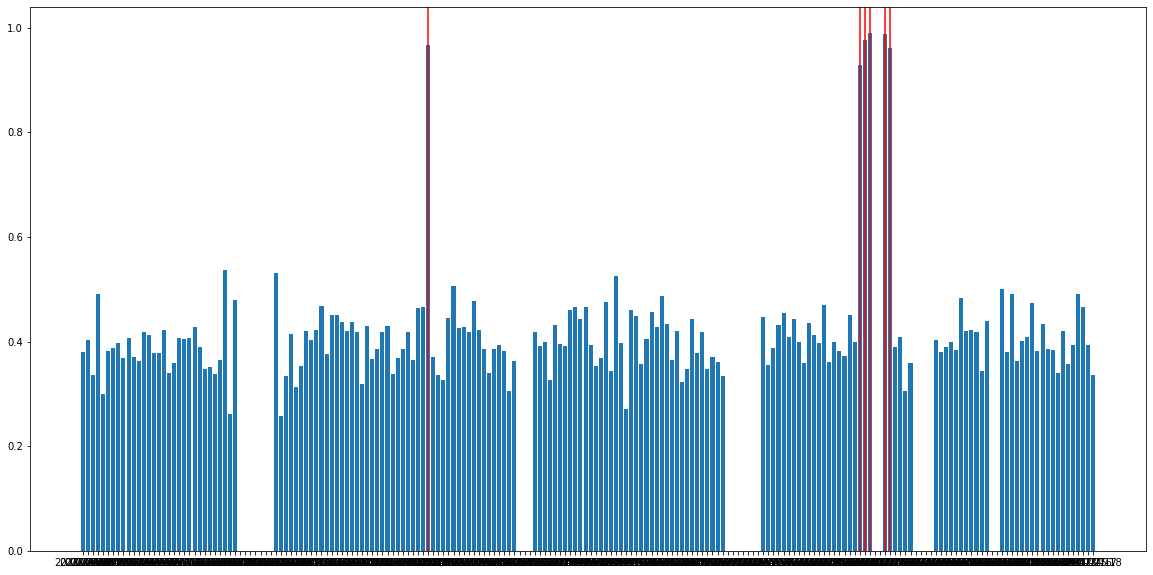

In [21]:
show_reports(null_rates, null_rate_anoms["date_added"], "avg_temp_null_rate")

Great work! In the next exercise, we'll build off of these simpler reports to handle scenarios with multiple tables and lineage information.